
--- Loading test data (without User_ID) ---
Test data successfully loaded.

--- Loading pre-trained models ---
Predictors loaded successfully.

--- Starting validation workflow ---
Best RMSE (Unscaled): 1.1654
Best RMSE (Scaled):   1.1516
--> Conclusion: The 'scaled' data predictor is better.

--- Simulating data drift ---
RMSE on ORIGINAL test data: 1.1516
Drift simulated by adding random noise to your specified features: ['Body_Temp', 'Heart_Rate'].
RMSE on MODIFIED test data: 11.1862

--- Visualizing drift impact on errors ---


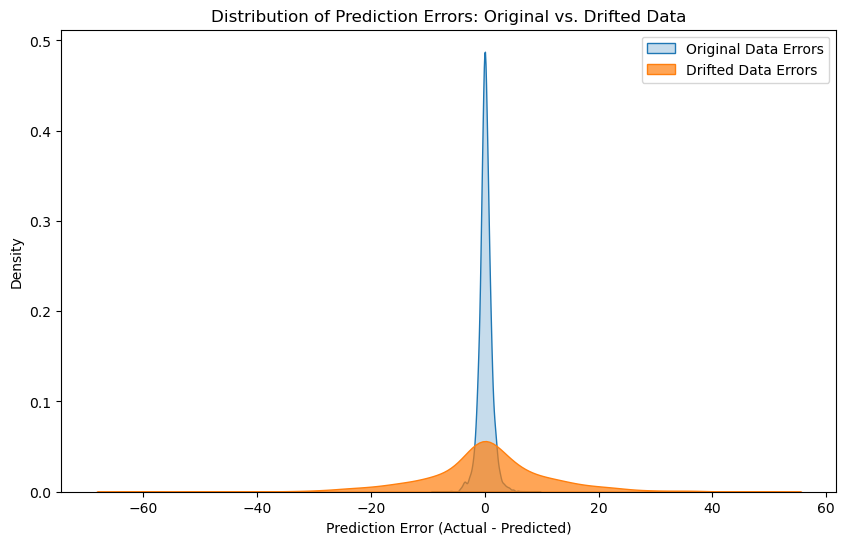


--- Validation Script Finished ---


In [2]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor, TabularDataset
import warnings

# Ignore non-critical warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# %%
# Step 1: Load Test Data
# ========================
# Load the test sets from your new 'autogluon_train_results' directory.
print("\n--- Loading test data (without User_ID) ---")
try:
    # UPDATED PATH: Pointing to the new folder for the data files.
    unscaled_path = 'autogluon_train_results/test_data_unscaled_noID.csv'
    scaled_path = 'autogluon_train_results/test_data_scaled_noID.csv'
    
    test_df_unscaled = pd.read_csv(unscaled_path)
    test_df_scaled = pd.read_csv(scaled_path)
    
    print("Test data successfully loaded.")
except FileNotFoundError:
    print(f"ERROR: Could not find test data files in '{'autogluon_train_results/'}'.")
    print("Please ensure the training script has run and saved the files to that location.")
    raise

# %%
# Step 2: Load Pre-Trained Models
# ===============================
# Load the predictors from your new 'autogluon_train_results' directory.
print("\n--- Loading pre-trained models ---")
try:
    # UPDATED PATH: Pointing to the new folder for the model directories.
    unscaled_model_path = 'autogluon_train_results/autogluon_unscaled/'
    scaled_model_path = 'autogluon_train_results/autogluon_scaled/'

    predictor_unscaled = TabularPredictor.load(unscaled_model_path)
    predictor_scaled = TabularPredictor.load(scaled_model_path)
    
    print("Predictors loaded successfully.")
except Exception as e:
    print(f"ERROR: Could not load model directories from '{'autogluon_train_results/'}'.")
    print("Please ensure the training script has run and saved the models to that location.")
    raise


# %%
# Step 3: Compare, Validate, and Simulate Data Drift
print("\n--- Starting validation workflow ---")

# Regenerate leaderboards
test_data_unscaled = TabularDataset(test_df_unscaled)
test_data_scaled = TabularDataset(test_df_scaled)
leaderboard_unscaled = predictor_unscaled.leaderboard(test_data_unscaled, silent=True)
leaderboard_scaled = predictor_scaled.leaderboard(test_data_scaled, silent=True)

# 1. Select the Best Predictor
score_unscaled = abs(leaderboard_unscaled.iloc[0]['score_test'])
score_scaled = abs(leaderboard_scaled.iloc[0]['score_test'])
print(f"Best RMSE (Unscaled): {score_unscaled:.4f}")
print(f"Best RMSE (Scaled):   {score_scaled:.4f}")

if score_scaled < score_unscaled:
    best_predictor = predictor_scaled
    test_df_to_use = test_df_scaled
    print("--> Conclusion: The 'scaled' data predictor is better.")
else:
    best_predictor = predictor_unscaled
    test_df_to_use = test_df_unscaled
    print("--> Conclusion: The 'unscaled' data predictor is better.")
    
# 2. Perform Data Drift Simulation
print("\n--- Simulating data drift ---")
X_test = test_df_to_use.drop(columns=['Calories'])
y_test = test_df_to_use['Calories']

# A) Predict on ORIGINAL data
predictions_original = best_predictor.predict(X_test)
rmse_original = np.sqrt(mean_squared_error(y_test, predictions_original))
print(f"RMSE on ORIGINAL test data: {rmse_original:.4f}")

# B) Simulate drift on 'Body_Temp' and 'Heart_Rate'
X_test_modified = X_test.copy()
cols_to_modify = ['Body_Temp', 'Heart_Rate']

# Generate and add subtle random noise
noise = np.random.normal(loc=0, scale=0.5, size=(len(X_test_modified), len(cols_to_modify)))
X_test_modified[cols_to_modify] += noise
print(f"Drift simulated by adding random noise to your specified features: {cols_to_modify}.")

# C) Predict on MODIFIED data
predictions_modified = best_predictor.predict(X_test_modified)
rmse_modified = np.sqrt(mean_squared_error(y_test, predictions_modified))
print(f"RMSE on MODIFIED test data: {rmse_modified:.4f}")

# 3. Visualize Drift Impact
print("\n--- Visualizing drift impact on errors ---")
errors_original = y_test - predictions_original
errors_modified = y_test - predictions_modified

plt.figure(figsize=(10, 6))
sns.kdeplot(errors_original, fill=True, label='Original Data Errors')
sns.kdeplot(errors_modified, fill=True, label='Drifted Data Errors', alpha=0.7)
plt.title('Distribution of Prediction Errors: Original vs. Drifted Data')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.legend()
plt.show()

print("\n--- Validation Script Finished ---")